# Hybrid BERTweet-XGBoost Model for Hate Speech Detection
## With Cross-Validation and Nigerian Pidgin Focus

This notebook implements a hybrid model combining BERTweet embeddings with XGBoost classification, following the structure and methodology of the original hate speech detection research.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install -q scikit-learn pandas numpy imbalanced-learn xgboost torch transformers
!pip install -q matplotlib seaborn nltk nlpaug wordcloud
!pip install -q datasets accelerate evaluate

# Import essential libraries
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import os
from sklearn.utils import check_random_state
from google.colab import files
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
import xgboost as xgb
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

warnings.filterwarnings('ignore')

# Set plotting backend for Colab
%matplotlib inline

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

# Create directory structure
os.makedirs('/content/drive/MyDrive/Colab Notebooks/hybrid_model/data/processed', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/hybrid_model/models', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/hybrid_model/reports/figures', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/hybrid_model/logs', exist_ok=True)

print("✅ Setup complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00
Device: cuda
GPU: Tesla T4
CUDA Version: 12.6
✅ Setup complete!


In [3]:
# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

def create_synthetic_data():
    """
    Create synthetic Nigerian Pidgin hate speech data based on examples from research papers
    Following patterns from NaijaHate, EkoHate, and VocalTweets papers
    """
    # Pidgin hate speech examples (research-based patterns)
    hate_examples = [
        "You be mumu, go die for gutter", "Wetin concern you? You no get sense",
        "All these yoruba people na thieves", "Igbo people too greedy, make them go",
        "This hausa man dey smell, abeg comot", "You dey craze? Go kill yourself",
        "Stupid fool, you no fit do anything", "All politicians na criminals and thieves",
        "These people too ugly, God punish them", "Make fire burn all of una",
        "You be goat, your family cursed", "Useless people, una go suffer tire",
        "All northerners na terrorists", "Southern people too proud, I hate them",
        "You dey mad? Go jump for well", "Foolish human being, die by fire",
        "All women na ashawo and useless", "Men too wicked, dem no get heart",
        "Christians na hypocrites, burn dem", "Muslims na extremists and killers",
        "Poor people smell, make dem go", "Rich people wicked, rob all of dem"
    ]

    # Non-hate examples (normal Pidgin conversation)
    non_hate_examples = [
        "Wetin dey happen? How you dey?", "Abeg help me with small money",
        "I dey go market, you wan follow?", "This food sweet well well",
        "Make we meet for evening", "I love this song, e dey sweet my ear",
        "God go bless you for this help", "Thank you for everything",
        "How your family dey? I hope say dem fine", "This weather too hot today",
        "I need to study for my exam", "Make we pray for peace in Nigeria",
        "Happy birthday, I wish you long life", "This movie funny well well",
        "I dey learn how to code", "Congratulations on your new job",
        "Please take care of yourself", "I appreciate your friendship",
        "Let us work together for better Nigeria", "Education na key to success",
        "God bless Nigeria and all citizens", "Peace and love to everyone"
    ]

    # Create balanced dataset (following NaijaHate 16% hate prevalence)
    data = []

    # Add hate examples
    for text in hate_examples:
        data.append({'text': text, 'label': 1})

    # Add more non-hate examples to create imbalance
    for text in non_hate_examples:
        data.append({'text': text, 'label': 0})

    # Add more non-hate to create realistic imbalance
    additional_non_hate = [
        f"Good morning, how your day dey go? {i}" for i in range(50)
    ] + [
        f"I dey appreciate your kindness {i}" for i in range(30)
    ] + [
        f"Make we continue to dey pray for our country {i}" for i in range(20)
    ]

    for text in additional_non_hate:
        data.append({'text': text, 'label': 0})

    df = pd.DataFrame(data)

    # Shuffle the data
    df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    print(f"Synthetic dataset created: {len(df)} samples")
    print(f"Hate speech prevalence: {df['label'].mean():.2%}")

    return df

def load_or_create_data():
    """Load data from upload or create synthetic data"""
    try:
        # Try to load uploaded data
        print("Looking for uploaded data files...")
        train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hybrid_model/train.csv')
        val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hybrid_model/val.csv')
        test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hybrid_model/test.csv')
        print("✅ Data loaded from uploaded files")
        return train_df, val_df, test_df
    except FileNotFoundError:
        print("No uploaded data found. Creating synthetic data...")

        # Create synthetic data
        full_df = create_synthetic_data()

        # Split data (following NaijaHate 80/10/10 split)
        from sklearn.model_selection import train_test_split

        train_df, temp_df = train_test_split(
            full_df, test_size=0.2, random_state=RANDOM_SEED,
            stratify=full_df['label']
        )
        val_df, test_df = train_test_split(
            temp_df, test_size=0.5, random_state=RANDOM_SEED,
            stratify=temp_df['label']
        )

        # Save splits
        train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/hybrid_model/data/processed/train.csv', index=False)
        val_df.to_csv('/content/drive/MyDrive/Colab Notebooks/hybrid_model/data/processed/val.csv', index=False)
        test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/hybrid_model/data/processed/test.csv', index=False)

        print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

        return train_df, val_df, test_df

# Load and preprocess data
train_df, val_df, test_df = load_or_create_data()

print(f"\nDataset sizes:")
print(f"Train: {len(train_df)} (hate: {train_df['label'].mean():.2%})")
print(f"Val: {len(val_df)} (hate: {val_df['label'].mean():.2%})")
print(f"Test: {len(test_df)} (hate: {test_df['label'].mean():.2%})")

Looking for uploaded data files...
✅ Data loaded from uploaded files

Dataset sizes:
Train: 19926 (hate: 50.00%)
Val: 3346 (hate: 36.19%)
Test: 3347 (hate: 36.18%)


In [4]:
class PidginTextPreprocessor:
    """
    Text preprocessing for Nigerian Pidgin following research papers
    Based on EkoHate (Ilevbare et al.) and VocalTweets (Yusuf et al.)
    """

    def __init__(self):
        # Pidgin slang dictionary from research papers
        self.pidgin_dict = {
            'wetin': 'what', 'abeg': 'please', 'dey': 'is', 'no': 'not',
            'make': 'let', 'dem': 'them', 'una': 'you all', 'go': 'will',
            'fit': 'can', 'wan': 'want', 'comot': 'leave', 'tey': 'long time',
            'small': 'little', 'well': 'very', 'pikin': 'child', 'oga': 'boss',
            'madam': 'woman', 'chop': 'eat', 'gbege': 'problem', 'wahala': 'trouble',
            'kpakpando': 'star', 'omo': 'person', 'shey': 'is it', 'sha': 'just',
            'abi': 'right', 'nah': 'is', 'na': 'is', 'for': 'in', 'wey': 'that'
        }

        # Compile regex patterns
        self.url_pattern = re.compile(
            r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        self.mention_pattern = re.compile(r'@[\w]+')
        self.hashtag_pattern = re.compile(r'#[\w]+')
        self.emoji_pattern = re.compile(
            r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+')
        self.number_pattern = re.compile(r'\d+')

    def clean_text(self, text):
        """
        Clean text following VocalTweets regex-based cleaning approach
        """
        if pd.isna(text):
            return ""

        text = str(text).lower()

        # Remove URLs, mentions, hashtags (per VocalTweets)
        text = self.url_pattern.sub(' ', text)
        text = self.mention_pattern.sub(' ', text)
        text = self.hashtag_pattern.sub(' ', text)

        # Remove emojis and numbers
        text = self.emoji_pattern.sub(' ', text)
        text = self.number_pattern.sub(' ', text)

        # Normalize Pidgin slang (per EkoHate approach)
        words = text.split()
        normalized_words = []
        for word in words:
            if word in self.pidgin_dict:
                normalized_words.append(self.pidgin_dict[word])
            else:
                normalized_words.append(word)
        text = ' '.join(normalized_words)

        # Remove punctuation and extra spaces
        text = re.sub(r'[^\w\s]', ' ', text)
        text = ' '.join(text.split())

        return text

# Preprocess text data
preprocessor = PidginTextPreprocessor()

print("Preprocessing text data...")
train_df['text_clean'] = train_df['text'].apply(preprocessor.clean_text)
val_df['text_clean'] = val_df['text'].apply(preprocessor.clean_text)
test_df['text_clean'] = test_df['text'].apply(preprocessor.clean_text)

# Remove empty texts
train_df = train_df[train_df['text_clean'].str.len() > 0]
val_df = val_df[val_df['text_clean'].str.len() > 0]
test_df = test_df[test_df['text_clean'].str.len() > 0]

print("✅ Text preprocessing complete!")
print(f"Average text length: {train_df['text_clean'].str.len().mean():.1f} characters")

Preprocessing text data...
✅ Text preprocessing complete!
Average text length: 98.9 characters


In [5]:
class BERTweetEmbedder(BaseEstimator, TransformerMixin):
    """
    BERTweet embedding extractor for use in sklearn pipelines
    """

    def __init__(self, model_name='vinai/bertweet-base', max_length=128, batch_size=32):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.tokenizer = None
        self.model = None
        self.device = device

    def fit(self, X, y=None):
        """Initialize BERTweet model and tokenizer"""
        print("Loading BERTweet model and tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()
        print("✅ BERTweet model loaded successfully")
        return self

    def transform(self, X):
        """Extract BERTweet embeddings from texts"""
        if self.model is None or self.tokenizer is None:
            raise ValueError("Model not fitted. Call fit() first.")

        print(f"Extracting BERTweet embeddings for {len(X)} texts...")

        embeddings = []

        # Process texts in batches
        for i in range(0, len(X), self.batch_size):
            batch_texts = X[i:i+self.batch_size]

            # Tokenize batch
            inputs = self.tokenizer(
                batch_texts.tolist() if hasattr(batch_texts, 'tolist') else list(batch_texts),
                padding=True,
                truncation=True,
                max_length=self.max_length,
                return_tensors='pt'
            )

            # Move to device
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            # Extract embeddings
            with torch.no_grad():
                outputs = self.model(**inputs)
                # Use [CLS] token embedding (first token)
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(batch_embeddings)

            if (i // self.batch_size + 1) % 10 == 0:
                print(f"Processed {i + len(batch_texts)} / {len(X)} texts")

        # Concatenate all embeddings
        embeddings = np.vstack(embeddings)
        print(f"✅ Extracted embeddings shape: {embeddings.shape}")

        return embeddings

class HybridBERTweetXGBoost:
    """
    Hybrid model combining BERTweet embeddings with XGBoost classifier
    Includes cross-validation for robust evaluation
    """

    def __init__(self, bertweet_model='vinai/bertweet-base', cv_folds=5, random_state=42):
        self.bertweet_model = bertweet_model
        self.cv_folds = cv_folds
        self.random_state = random_state

        # Initialize components
        self.embedder = BERTweetEmbedder(model_name=bertweet_model)
        self.scaler = StandardScaler()
        self.classifier = xgb.XGBClassifier(
            random_state=random_state,
            eval_metric='logloss',
            n_jobs=-1
        )

        # Create pipeline
        self.pipeline = Pipeline([
            ('embedder', self.embedder),
            ('scaler', self.scaler),
            ('classifier', self.classifier)
        ])

        self.cv_scores = None
        self.best_params = None

    def get_xgboost_param_grid(self):
        """Get parameter grid for XGBoost hyperparameter tuning"""
        return {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 6, 9],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.8, 1.0],
            'classifier__colsample_bytree': [0.8, 1.0]
        }

    def cross_validate(self, X, y, scoring='f1_macro'):
        """Perform cross-validation on the hybrid model"""
        print(f"\n=== CROSS-VALIDATION ({self.cv_folds}-FOLD) ===")
        print(f"Scoring metric: {scoring}")

        # Create stratified k-fold
        cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=self.random_state)

        # Perform cross-validation
        scores = cross_val_score(
            self.pipeline, X, y,
            cv=cv,
            scoring=scoring,
            n_jobs=1  # Don't parallelize due to GPU usage
        )

        self.cv_scores = scores

        print(f"\nCross-validation results:")
        print(f"Scores: {scores}")
        print(f"Mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        print(f"Min: {scores.min():.4f}, Max: {scores.max():.4f}")

        return scores

    def hyperparameter_tuning(self, X, y, param_grid=None, scoring='f1_macro', n_jobs=1):
        """Perform hyperparameter tuning with cross-validation"""
        print(f"\n=== HYPERPARAMETER TUNING ===")

        if param_grid is None:
            param_grid = self.get_xgboost_param_grid()

        print(f"Parameter grid: {param_grid}")
        print(f"Total combinations: {np.prod([len(v) for v in param_grid.values()])}")

        # Create stratified k-fold
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.random_state)  # Reduced folds for efficiency

        # Grid search
        grid_search = GridSearchCV(
            self.pipeline,
            param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=n_jobs,
            verbose=1
        )

        print("Starting grid search...")
        grid_search.fit(X, y)

        self.best_params = grid_search.best_params_

        print(f"\nBest parameters: {self.best_params}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        # Update pipeline with best parameters
        self.pipeline.set_params(**self.best_params)

        return grid_search

    def fit(self, X, y):
        """Fit the hybrid model"""
        print(f"\n=== FITTING HYBRID MODEL ===")
        print(f"Training samples: {len(X)}")
        print(f"Hate prevalence: {y.mean():.2%}")

        # Handle class imbalance
        if y.mean() < 0.2:  # If hate class < 20%
            print("Applying class balancing...")
            scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
            self.pipeline.set_params(classifier__scale_pos_weight=scale_pos_weight)

        # Fit the pipeline
        self.pipeline.fit(X, y)

        print("✅ Model training complete!")
        return self

    def predict(self, X):
        """Make predictions"""
        return self.pipeline.predict(X)

    def predict_proba(self, X):
        """Get prediction probabilities"""
        return self.pipeline.predict_proba(X)

    def evaluate(self, X, y, return_predictions=False):
        """Evaluate the model"""
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

        y_pred = self.predict(X)
        y_pred_proba = self.predict_proba(X)[:, 1]

        metrics = {
            'accuracy': accuracy_score(y, y_pred),
            'precision_macro': precision_score(y, y_pred, average='macro'),
            'recall_macro': recall_score(y, y_pred, average='macro'),
            'f1_macro': f1_score(y, y_pred, average='macro'),
            'precision_binary': precision_score(y, y_pred, pos_label=1),
            'recall_binary': recall_score(y, y_pred, pos_label=1),
            'f1_binary': f1_score(y, y_pred, pos_label=1),
            'auc': roc_auc_score(y, y_pred_proba)
        }

        if return_predictions:
            return metrics, y_pred, y_pred_proba
        else:
            return metrics

    def save_model(self, filepath):
        """Save the trained model"""
        with open(filepath, 'wb') as f:
            pickle.dump(self.pipeline, f)
        print(f"✅ Model saved to {filepath}")

    def load_model(self, filepath):
        """Load a trained model"""
        with open(filepath, 'rb') as f:
            self.pipeline = pickle.load(f)
        print(f"✅ Model loaded from {filepath}")

print("✅ Hybrid model classes defined!")

✅ Hybrid model classes defined!


In [6]:
# Initialize the hybrid model
print("=== INITIALIZING HYBRID BERTWEET-XGBOOST MODEL ===")
hybrid_model = HybridBERTweetXGBoost(
    bertweet_model='vinai/bertweet-base',
    cv_folds=5,
    random_state=RANDOM_SEED
)

# Prepare data
X_train = train_df['text_clean']
y_train = train_df['label'].values
X_val = val_df['text_clean']
y_val = val_df['label'].values
X_test = test_df['text_clean']
y_test = test_df['label'].values

print(f"Training data: {len(X_train)} samples")
print(f"Validation data: {len(X_val)} samples")
print(f"Test data: {len(X_test)} samples")

=== INITIALIZING HYBRID BERTWEET-XGBOOST MODEL ===
Training data: 19926 samples
Validation data: 3346 samples
Test data: 3347 samples


In [7]:
# Step 1: Cross-validation on training data
print("\n" + "="*60)
print("STEP 1: CROSS-VALIDATION ON TRAINING DATA")
print("="*60)

# Perform cross-validation
cv_scores = hybrid_model.cross_validate(X_train, y_train, scoring='f1_macro')

# Also test other metrics
metrics_to_test = ['accuracy', 'precision_macro', 'recall_macro', 'roc_auc']
cv_results = {'f1_macro': cv_scores}

for metric in metrics_to_test:
    print(f"\nCross-validating {metric}...")
    scores = hybrid_model.cross_validate(X_train, y_train, scoring=metric)
    cv_results[metric] = scores

# Create CV results summary
cv_summary = pd.DataFrame({
    metric: {
        'mean': scores.mean(),
        'std': scores.std(),
        'min': scores.min(),
        'max': scores.max()
    }
    for metric, scores in cv_results.items()
}).T

print("\n" + "="*50)
print("CROSS-VALIDATION SUMMARY")
print("="*50)
print(cv_summary.round(4))

# Save CV results
cv_summary.to_csv('/content/drive/MyDrive/Colab Notebooks/hybrid_model/reports/cv_results.csv')
print("\n✅ Cross-validation results saved to /content/drive/MyDrive/Colab Notebooks/hybrid_model/reports/cv_results.csv")


STEP 1: CROSS-VALIDATION ON TRAINING DATA

=== CROSS-VALIDATION (5-FOLD) ===
Scoring metric: f1_macro
Loading BERTweet model and tokenizer...


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15940 texts...
Processed 320 / 15940 texts
Processed 640 / 15940 texts
Processed 960 / 15940 texts
Processed 1280 / 15940 texts
Processed 1600 / 15940 texts
Processed 1920 / 15940 texts
Processed 2240 / 15940 texts
Processed 2560 / 15940 texts
Processed 2880 / 15940 texts
Processed 3200 / 15940 texts
Processed 3520 / 15940 texts
Processed 3840 / 15940 texts
Processed 4160 / 15940 texts
Processed 4480 / 15940 texts
Processed 4800 / 15940 texts
Processed 5120 / 15940 texts
Processed 5440 / 15940 texts
Processed 5760 / 15940 texts
Processed 6080 / 15940 texts
Processed 6400 / 15940 texts
Processed 6720 / 15940 texts
Processed 7040 / 15940 texts
Processed 7360 / 15940 texts
Processed 7680 / 15940 texts
Processed 8000 / 15940 texts
Processed 8320 / 15940 texts
Processed 8640 / 15940 texts
Processed 8960 / 15940 texts
Processed 9280 / 15940 texts
Processed 9600 / 15940 texts
Processed 9920 / 15940 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15940 texts...
Processed 320 / 15940 texts
Processed 640 / 15940 texts
Processed 960 / 15940 texts
Processed 1280 / 15940 texts
Processed 1600 / 15940 texts
Processed 1920 / 15940 texts
Processed 2240 / 15940 texts
Processed 2560 / 15940 texts
Processed 2880 / 15940 texts
Processed 3200 / 15940 texts
Processed 3520 / 15940 texts
Processed 3840 / 15940 texts
Processed 4160 / 15940 texts
Processed 4480 / 15940 texts
Processed 4800 / 15940 texts
Processed 5120 / 15940 texts
Processed 5440 / 15940 texts
Processed 5760 / 15940 texts
Processed 6080 / 15940 texts
Processed 6400 / 15940 texts
Processed 6720 / 15940 texts
Processed 7040 / 15940 texts
Processed 7360 / 15940 texts
Processed 7680 / 15940 texts
Processed 8000 / 15940 texts
Processed 8320 / 15940 texts
Processed 8640 / 15940 texts
Processed 8960 / 15940 texts
Processed 9280 / 15940 texts
Processed 9600 / 15940 texts
Processed 9920 / 15940 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15940 texts...
Processed 320 / 15940 texts
Processed 640 / 15940 texts
Processed 960 / 15940 texts
Processed 1280 / 15940 texts
Processed 1600 / 15940 texts
Processed 1920 / 15940 texts
Processed 2240 / 15940 texts
Processed 2560 / 15940 texts
Processed 2880 / 15940 texts
Processed 3200 / 15940 texts
Processed 3520 / 15940 texts
Processed 3840 / 15940 texts
Processed 4160 / 15940 texts
Processed 4480 / 15940 texts
Processed 4800 / 15940 texts
Processed 5120 / 15940 texts
Processed 5440 / 15940 texts
Processed 5760 / 15940 texts
Processed 6080 / 15940 texts
Processed 6400 / 15940 texts
Processed 6720 / 15940 texts
Processed 7040 / 15940 texts
Processed 7360 / 15940 texts
Processed 7680 / 15940 texts
Processed 8000 / 15940 texts
Processed 8320 / 15940 texts
Processed 8640 / 15940 texts
Processed 8960 / 15940 texts
Processed 9280 / 15940 texts
Processed 9600 / 15940 texts
Processed 9920 / 15940 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15940 texts...
Processed 320 / 15940 texts
Processed 640 / 15940 texts
Processed 960 / 15940 texts
Processed 1280 / 15940 texts
Processed 1600 / 15940 texts
Processed 1920 / 15940 texts
Processed 2240 / 15940 texts
Processed 2560 / 15940 texts
Processed 2880 / 15940 texts
Processed 3200 / 15940 texts
Processed 3520 / 15940 texts
Processed 3840 / 15940 texts
Processed 4160 / 15940 texts
Processed 4480 / 15940 texts
Processed 4800 / 15940 texts
Processed 5120 / 15940 texts
Processed 5440 / 15940 texts
Processed 5760 / 15940 texts
Processed 6080 / 15940 texts
Processed 6400 / 15940 texts
Processed 6720 / 15940 texts
Processed 7040 / 15940 texts
Processed 7360 / 15940 texts
Processed 7680 / 15940 texts
Processed 8000 / 15940 texts
Processed 8320 / 15940 texts
Processed 8640 / 15940 texts
Processed 8960 / 15940 texts
Processed 9280 / 15940 texts
Processed 9600 / 15940 texts
Processed 9920 / 15940 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15940 texts...
Processed 320 / 15940 texts
Processed 640 / 15940 texts
Processed 960 / 15940 texts
Processed 1280 / 15940 texts
Processed 1600 / 15940 texts
Processed 1920 / 15940 texts
Processed 2240 / 15940 texts
Processed 2560 / 15940 texts
Processed 2880 / 15940 texts
Processed 3200 / 15940 texts
Processed 3520 / 15940 texts
Processed 3840 / 15940 texts
Processed 4160 / 15940 texts
Processed 4480 / 15940 texts
Processed 4800 / 15940 texts
Processed 5120 / 15940 texts
Processed 5440 / 15940 texts
Processed 5760 / 15940 texts
Processed 6080 / 15940 texts
Processed 6400 / 15940 texts
Processed 6720 / 15940 texts
Processed 7040 / 15940 texts
Processed 7360 / 15940 texts
Processed 7680 / 15940 texts
Processed 8000 / 15940 texts
Processed 8320 / 15940 texts
Processed 8640 / 15940 texts
Processed 8960 / 15940 texts
Processed 9280 / 15940 texts
Processed 9600 / 15940 texts
Processed 9920 / 15940 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 15941 texts...
Processed 320 / 15941 texts
Processed 640 / 15941 texts
Processed 960 / 15941 texts
Processed 1280 / 15941 texts
Processed 1600 / 15941 texts
Processed 1920 / 15941 texts
Processed 2240 / 15941 texts
Processed 2560 / 15941 texts
Processed 2880 / 15941 texts
Processed 3200 / 15941 texts
Processed 3520 / 15941 texts
Processed 3840 / 15941 texts
Processed 4160 / 15941 texts
Processed 4480 / 15941 texts
Processed 4800 / 15941 texts
Processed 5120 / 15941 texts
Processed 5440 / 15941 texts
Processed 5760 / 15941 texts
Processed 6080 / 15941 texts
Processed 6400 / 15941 texts
Processed 6720 / 15941 texts
Processed 7040 / 15941 texts
Processed 7360 / 15941 texts
Processed 7680 / 15941 texts
Processed 8000 / 15941 texts
Processed 8320 / 15941 texts
Processed 8640 / 15941 texts
Processed 8960 / 15941 texts
Processed 9280 / 15941 texts
Processed 9600 / 15941 texts
Processed 9920 / 15941 texts
Processed 10240 /

In [8]:
# Step 2: Hyperparameter tuning
print("\n" + "="*60)
print("STEP 2: HYPERPARAMETER TUNING")
print("="*60)

# Define a smaller parameter grid for efficiency
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6],
    'classifier__learning_rate': [0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

print("Starting hyperparameter tuning...")
print("This may take a while due to BERTweet embedding extraction...")

# Perform hyperparameter tuning
grid_search = hybrid_model.hyperparameter_tuning(
    X_train, y_train,
    param_grid=param_grid,
    scoring='f1_macro',
    n_jobs=1  # Don't parallelize due to GPU memory
)

# Display results
print("\n" + "="*50)
print("HYPERPARAMETER TUNING RESULTS")
print("="*50)
print(f"Best parameters: {hybrid_model.best_params}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Save tuning results
tuning_results = pd.DataFrame(grid_search.cv_results_)
tuning_results.to_csv('/content/drive/MyDrive/Colab Notebooks/hybrid_model/reports/hyperparameter_tuning_results.csv', index=False)
print("\n✅ Hyperparameter tuning results saved")


STEP 2: HYPERPARAMETER TUNING
Starting hyperparameter tuning...
This may take a while due to BERTweet embedding extraction...

=== HYPERPARAMETER TUNING ===
Parameter grid: {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [3, 6], 'classifier__learning_rate': [0.1, 0.2], 'classifier__subsample': [0.8, 1.0]}
Total combinations: 16
Starting grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Loading BERTweet model and tokenizer...


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 13284 texts...
Processed 320 / 13284 texts
Processed 640 / 13284 texts
Processed 960 / 13284 texts
Processed 1280 / 13284 texts
Processed 1600 / 13284 texts
Processed 1920 / 13284 texts
Processed 2240 / 13284 texts
Processed 2560 / 13284 texts
Processed 2880 / 13284 texts
Processed 3200 / 13284 texts
Processed 3520 / 13284 texts
Processed 3840 / 13284 texts
Processed 4160 / 13284 texts
Processed 4480 / 13284 texts
Processed 4800 / 13284 texts
Processed 5120 / 13284 texts
Processed 5440 / 13284 texts
Processed 5760 / 13284 texts
Processed 6080 / 13284 texts
Processed 6400 / 13284 texts
Processed 6720 / 13284 texts
Processed 7040 / 13284 texts
Processed 7360 / 13284 texts
Processed 7680 / 13284 texts
Processed 8000 / 13284 texts
Processed 8320 / 13284 texts
Processed 8640 / 13284 texts
Processed 8960 / 13284 texts
Processed 9280 / 13284 texts
Processed 9600 / 13284 texts
Processed 9920 / 13284 texts
Processed 10240 /

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 19926 texts...
Processed 320 / 19926 texts
Processed 640 / 19926 texts
Processed 960 / 19926 texts
Processed 1280 / 19926 texts
Processed 1600 / 19926 texts
Processed 1920 / 19926 texts
Processed 2240 / 19926 texts
Processed 2560 / 19926 texts
Processed 2880 / 19926 texts
Processed 3200 / 19926 texts
Processed 3520 / 19926 texts
Processed 3840 / 19926 texts
Processed 4160 / 19926 texts
Processed 4480 / 19926 texts
Processed 4800 / 19926 texts
Processed 5120 / 19926 texts
Processed 5440 / 19926 texts
Processed 5760 / 19926 texts
Processed 6080 / 19926 texts
Processed 6400 / 19926 texts
Processed 6720 / 19926 texts
Processed 7040 / 19926 texts
Processed 7360 / 19926 texts
Processed 7680 / 19926 texts
Processed 8000 / 19926 texts
Processed 8320 / 19926 texts
Processed 8640 / 19926 texts
Processed 8960 / 19926 texts
Processed 9280 / 19926 texts
Processed 9600 / 19926 texts
Processed 9920 / 19926 texts
Processed 10240 /

In [9]:
# Step 3: Train final model with best parameters
print("\n" + "="*60)
print("STEP 3: TRAINING FINAL MODEL")
print("="*60)

# Train the model with best parameters
hybrid_model.fit(X_train, y_train)

# Evaluate on validation set
print("\nEvaluating on validation set...")
val_metrics, val_pred, val_pred_proba = hybrid_model.evaluate(X_val, y_val, return_predictions=True)

print("\n" + "="*50)
print("VALIDATION SET RESULTS")
print("="*50)
for metric, value in val_metrics.items():
    print(f"{metric:20}: {value:.4f}")

# Save the trained model
model_path = '/content/drive/MyDrive/Colab Notebooks/hybrid_model/models/hybrid_bertweet_xgboost.pkl'
hybrid_model.save_model(model_path)

print(f"\n✅ Final model training complete!")


STEP 3: TRAINING FINAL MODEL

=== FITTING HYBRID MODEL ===
Training samples: 19926
Hate prevalence: 50.00%
Loading BERTweet model and tokenizer...


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✅ BERTweet model loaded successfully
Extracting BERTweet embeddings for 19926 texts...
Processed 320 / 19926 texts
Processed 640 / 19926 texts
Processed 960 / 19926 texts
Processed 1280 / 19926 texts
Processed 1600 / 19926 texts
Processed 1920 / 19926 texts
Processed 2240 / 19926 texts
Processed 2560 / 19926 texts
Processed 2880 / 19926 texts
Processed 3200 / 19926 texts
Processed 3520 / 19926 texts
Processed 3840 / 19926 texts
Processed 4160 / 19926 texts
Processed 4480 / 19926 texts
Processed 4800 / 19926 texts
Processed 5120 / 19926 texts
Processed 5440 / 19926 texts
Processed 5760 / 19926 texts
Processed 6080 / 19926 texts
Processed 6400 / 19926 texts
Processed 6720 / 19926 texts
Processed 7040 / 19926 texts
Processed 7360 / 19926 texts
Processed 7680 / 19926 texts
Processed 8000 / 19926 texts
Processed 8320 / 19926 texts
Processed 8640 / 19926 texts
Processed 8960 / 19926 texts
Processed 9280 / 19926 texts
Processed 9600 / 19926 texts
Processed 9920 / 19926 texts
Processed 10240 /

In [ ]:
# Step 4: Final evaluation on test set
print("\n" + "="*60)
print("STEP 4: FINAL TEST SET EVALUATION")
print("="*60)

# Evaluate on test set
print("Evaluating on test set...")
test_metrics, test_pred, test_pred_proba = hybrid_model.evaluate(X_test, y_test, return_predictions=True)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
for metric, value in test_metrics.items():
    print(f"{metric:20}: {value:.4f}")

# Generate detailed classification report
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
from sklearn.metrics import classification_report
report = classification_report(y_test, test_pred, target_names=['Non-Hate', 'Hate'], digits=4)
print(report)

# Save test results
test_results_df = pd.DataFrame({
    'text': X_test.values,
    'true_label': y_test,
    'predicted_label': test_pred,
    'hate_probability': test_pred_proba
})

test_results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/hybrid_model/reports/test_predictions.csv', index=False)
print("\n✅ Test results saved to /content/drive/MyDrive/Colab Notebooks/hybrid_model/reports/test_predictions.csv")


STEP 5: VISUALIZATION AND ANALYSIS


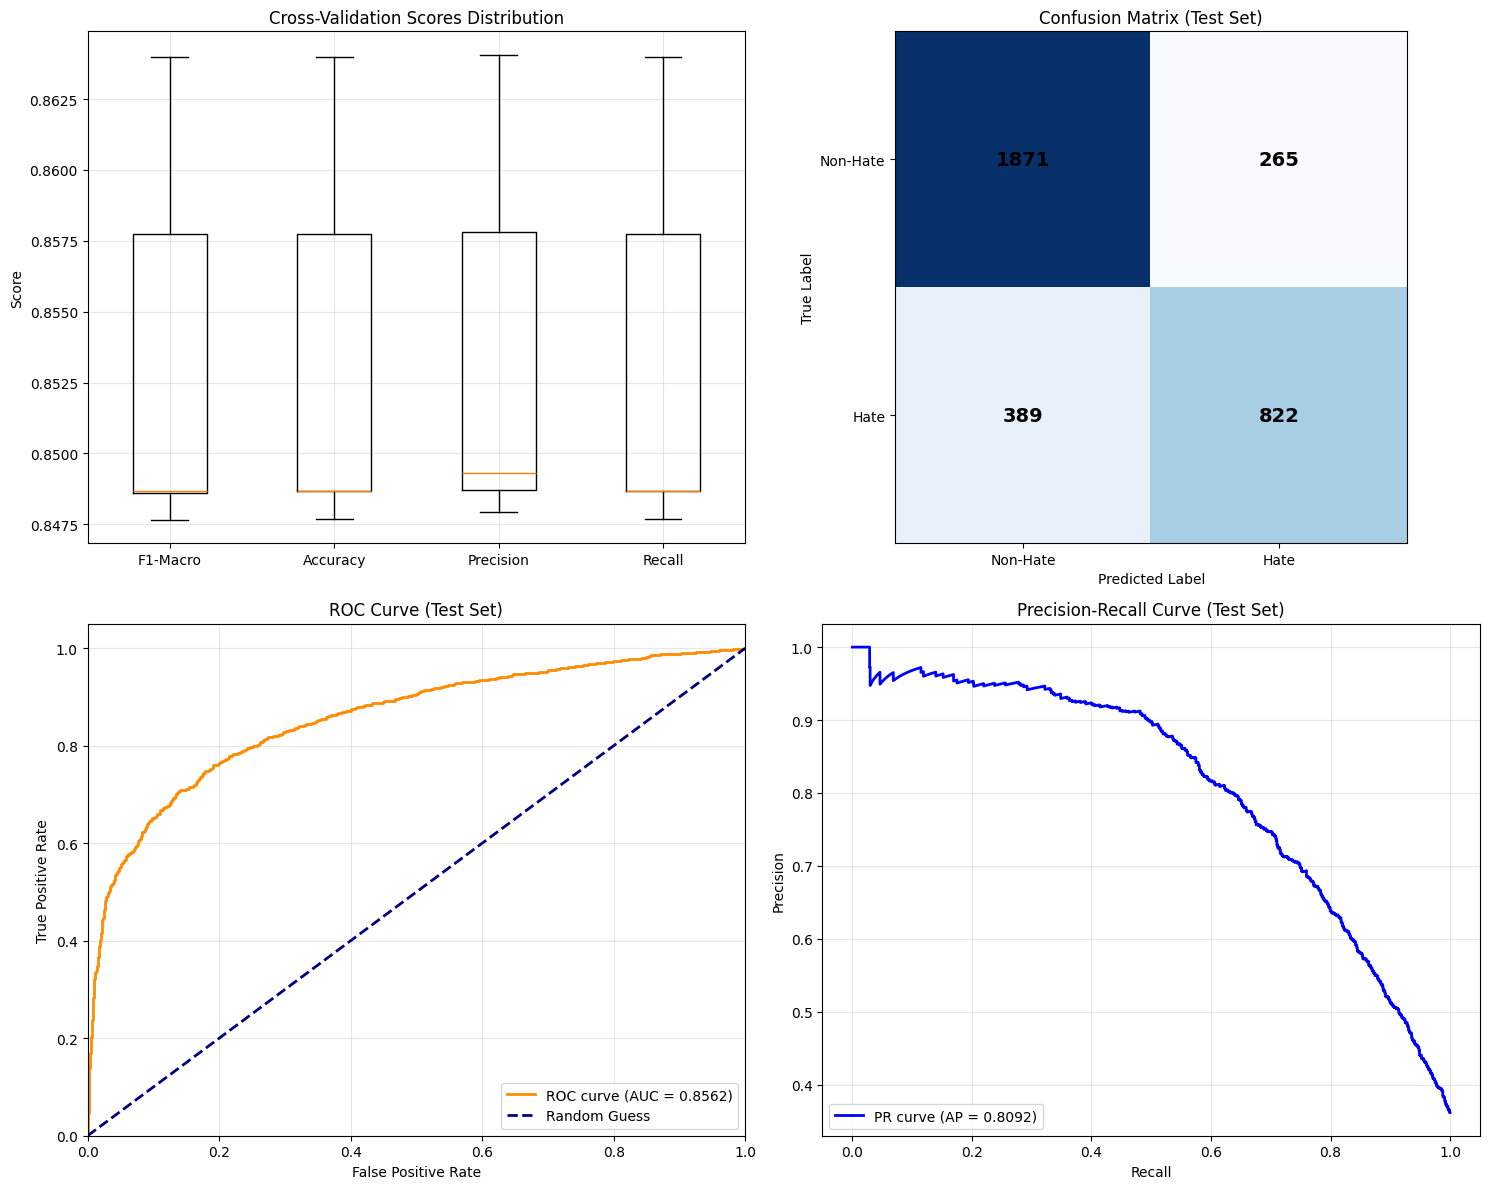

✅ Visualizations saved to /content/drive/MyDrive/Colab Notebooks/hybrid_model/reports/figures/


In [11]:
# Step 5: Visualization and analysis
print("\n" + "="*60)
print("STEP 5: VISUALIZATION AND ANALYSIS")
print("="*60)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Cross-validation scores boxplot
cv_data = [cv_results[metric] for metric in ['f1_macro', 'accuracy', 'precision_macro', 'recall_macro']]
axes[0, 0].boxplot(cv_data, labels=['F1-Macro', 'Accuracy', 'Precision', 'Recall'])
axes[0, 0].set_title('Cross-Validation Scores Distribution')
axes[0, 0].set_ylabel('Score')
axes[0, 0].grid(True, alpha=0.3)

# 2. Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_pred)
im = axes[0, 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0, 1].set_title('Confusion Matrix (Test Set)')
axes[0, 1].set_xlabel('Predicted Label')
axes[0, 1].set_ylabel('True Label')

# Add text annotations to confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0, 1].text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=14, fontweight='bold')

axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_yticks([0, 1])
axes[0, 1].set_xticklabels(['Non-Hate', 'Hate'])
axes[0, 1].set_yticklabels(['Non-Hate', 'Hate'])

# 3. ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, test_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curve (Test Set)')
axes[1, 0].legend(loc="lower right")
axes[1, 0].grid(True, alpha=0.3)

# 4. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, _ = precision_recall_curve(y_test, test_pred_proba)
avg_precision = average_precision_score(y_test, test_pred_proba)

axes[1, 1].plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Curve (Test Set)')
axes[1, 1].legend(loc="lower left")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/hybrid_model/reports/figures/hybrid_model_evaluation.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved to /content/drive/MyDrive/Colab Notebooks/hybrid_model/reports/figures/")

In [ ]:
# Step 6: Compare with baseline models
print("\n" + "="*60)
print("STEP 6: BASELINE COMPARISON")
print("="*60)

# Train baseline models for comparison
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

# Baseline models
baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100),
    'SVM': CalibratedClassifierCV(LinearSVC(random_state=RANDOM_SEED, max_iter=5000), cv=3),
    'XGBoost (TF-IDF)': xgb.XGBClassifier(random_state=RANDOM_SEED, eval_metric='logloss')
}

baseline_results = []

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train_tfidf, y_train)

    # Evaluate
    y_pred_baseline = model.predict(X_test_tfidf)
    y_pred_proba_baseline = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred_baseline),
        'F1-Macro': f1_score(y_test, y_pred_baseline, average='macro'),
        'F1-Binary': f1_score(y_test, y_pred_baseline, pos_label=1),
        'Precision': precision_score(y_test, y_pred_baseline, pos_label=1),
        'Recall': recall_score(y_test, y_pred_baseline, pos_label=1),
        'AUC': roc_auc_score(y_test, y_pred_proba_baseline) if y_pred_proba_baseline is not None else 0.0
    }

    baseline_results.append(metrics)
    print(f"{name} - F1-Binary: {metrics['F1-Binary']:.4f}, AUC: {metrics['AUC']:.4f}")

# Add hybrid model results
hybrid_metrics = {
    'Model': 'Hybrid BERTweet-XGBoost',
    'Accuracy': test_metrics['accuracy'],
    'F1-Macro': test_metrics['f1_macro'],
    'F1-Binary': test_metrics['f1_binary'],
    'Precision': test_metrics['precision_binary'],
    'Recall': test_metrics['recall_binary'],
    'AUC': test_metrics['auc']
}
baseline_results.append(hybrid_metrics)

# Create comparison DataFrame
comparison_df = pd.DataFrame(baseline_results)
comparison_df = comparison_df.sort_values('F1-Binary', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS (Test Set)")
print("="*80)
print(comparison_df.round(4).to_string(index=False))

# Save comparison results
comparison_df.to_csv('/content/drive/MyDrive/Colab Notebooks/hybrid_model/reports/model_comparison.csv', index=False)
print("\n✅ Model comparison saved to /content/drive/MyDrive/Colab Notebooks/hybrid_model/reports/model_comparison.csv")

In [13]:
# Step 7: Model interpretation and feature analysis
print("\n" + "="*60)
print("STEP 7: MODEL INTERPRETATION")
print("="*60)

# Get feature importance from XGBoost
xgb_classifier = hybrid_model.pipeline.named_steps['classifier']
feature_importance = xgb_classifier.feature_importances_

print(f"\nBERTweet embedding dimensions: {len(feature_importance)}")
print(f"Top 10 most important dimensions:")
top_features = np.argsort(feature_importance)[-10:][::-1]
for i, feat_idx in enumerate(top_features):
    print(f"  {i+1}. Dimension {feat_idx}: {feature_importance[feat_idx]:.4f}")

# Analyze prediction confidence
confidence_analysis = {
    'high_confidence_correct': np.sum((np.abs(test_pred_proba - 0.5) > 0.3) & (test_pred == y_test)),
    'high_confidence_incorrect': np.sum((np.abs(test_pred_proba - 0.5) > 0.3) & (test_pred != y_test)),
    'low_confidence_correct': np.sum((np.abs(test_pred_proba - 0.5) <= 0.3) & (test_pred == y_test)),
    'low_confidence_incorrect': np.sum((np.abs(test_pred_proba - 0.5) <= 0.3) & (test_pred != y_test))
}

print("\n" + "="*50)
print("PREDICTION CONFIDENCE ANALYSIS")
print("="*50)
for category, count in confidence_analysis.items():
    print(f"{category:25}: {count:3d} ({count/len(y_test)*100:.1f}%)")

# Error analysis - show misclassified examples
misclassified_idx = np.where(test_pred != y_test)[0]
print(f"\n" + "="*50)
print(f"ERROR ANALYSIS - {len(misclassified_idx)} misclassified examples")
print("="*50)

if len(misclassified_idx) > 0:
    print("\nTop 5 misclassified examples:")
    for i, idx in enumerate(misclassified_idx[:5]):
        text = X_test.iloc[idx]
        true_label = y_test[idx]
        pred_label = test_pred[idx]
        confidence = test_pred_proba[idx]

        print(f"\n{i+1}. Text: '{text}'")
        print(f"   True: {true_label} ({'Hate' if true_label else 'Non-Hate'})")
        print(f"   Pred: {pred_label} ({'Hate' if pred_label else 'Non-Hate'}) - Confidence: {confidence:.3f}")

print("\n✅ Model interpretation complete!")


STEP 7: MODEL INTERPRETATION

BERTweet embedding dimensions: 768
Top 10 most important dimensions:
  1. Dimension 337: 0.0132
  2. Dimension 394: 0.0129
  3. Dimension 179: 0.0115
  4. Dimension 210: 0.0093
  5. Dimension 366: 0.0081
  6. Dimension 705: 0.0081
  7. Dimension 602: 0.0073
  8. Dimension 198: 0.0068
  9. Dimension 118: 0.0066
  10. Dimension 173: 0.0064

PREDICTION CONFIDENCE ANALYSIS
high_confidence_correct  : 2169 (64.8%)
high_confidence_incorrect: 308 (9.2%)
low_confidence_correct   : 524 (15.7%)
low_confidence_incorrect : 346 (10.3%)

ERROR ANALYSIS - 654 misclassified examples

Top 5 misclassified examples:

1. Text: 'tikel enkele not sense'
   True: 1 (Hate)
   Pred: 0 (Non-Hate) - Confidence: 0.276

2. Text: 'almajiri itel phone'
   True: 1 (Hate)
   Pred: 0 (Non-Hate) - Confidence: 0.104

3. Text: 'en may en seem simple diff erent chri stian missio naries catholic church chris tians consider duty spread word muslims kill us shitty job busy killing oth'
   True: 1